In [5]:
import pandas as pd
import numpy as np
import random
import re
import pymorphy2

random.seed(1)

In [1]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle

In [3]:
train = pd.read_csv('orig_datasets/classification/train.tsv', sep='\t', index_col='tweet_id')
valid = pd.read_csv('orig_datasets/classification/valid.tsv', sep='\t', index_col='tweet_id')

#### Datasets size

In [4]:
train.shape[0]

17270

In [5]:
train['label'].value_counts()

0    15735
1     1535
Name: label, dtype: int64

In [6]:
valid.shape[0]

3425

In [7]:
valid['label'].value_counts()

0    3126
1     299
Name: label, dtype: int64

#### Tweet preprocessing

In [9]:
def normalize_tweet(tweet):
    tweet_norm = re.sub(r'(\xa0|\u200a|\u2028|\u3000)', ' ', tweet)
    tweet_norm = re.sub(r'\xad', '', tweet_norm)
    tweet_norm = re.sub(r'&amp;', '&', tweet_norm)
    tweet_norm = re.sub(r'&gt;', '>', tweet_norm)
    tweet_norm = re.sub(r'&lt;', '<', tweet_norm)
    tweet_norm = re.sub(r'&quot;', '"', tweet_norm)
    tweet_norm = re.sub(r'&laquo;', '«', tweet_norm)
    tweet_norm = re.sub(r'&raquo;', '»', tweet_norm)
    tweet_norm = re.sub(r'&#8230;', '...', tweet_norm)
    tweet_norm = re.sub(r'&#13;', ' ', tweet_norm)
    tweet_norm = re.sub(r'@\w+', '@username', tweet_norm)
    tweet_norm = re.sub(r'https://t.co/[\w\d]+', 'https', tweet_norm)
    return tweet_norm

In [10]:
def tokenize_tweet(tweet):
    tweet_tok = re.findall(r'@username|#[\w\d]+|[^\W\d_]+|[0-9]+', tweet)
    return ' '.join(tweet_tok)

In [11]:
morph = pymorphy2.MorphAnalyzer()

In [12]:
def normalize_tokens(tweet):
    tokens_norm = []
    for token in tweet.split():
        if not token.startswith(('@', '#')):
            tokens_norm.append(morph.parse(token)[0].normal_form)
        else:
            tokens_norm.append(token)
    return ' '.join(tokens_norm)

In [13]:
def prep_tweet(tweet):
    prep_tweet = normalize_tweet(tweet)
    prep_tweet = tokenize_tweet(prep_tweet)
    prep_tweet = normalize_tokens(prep_tweet)
    return prep_tweet

In [14]:
train['prep_tweet'] = train['tweet'].apply(lambda x: prep_tweet(x))
valid['prep_tweet'] = valid['tweet'].apply(lambda x: prep_tweet(x))

#### Train and valid

In [23]:
train = shuffle(train)

In [15]:
X = train['prep_tweet']
y = train['label']

In [25]:
X_valid = valid['prep_tweet']
y_valid = valid['label']

#### Train Dataset Cross validation

In [26]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(token_pattern=r'@username|#[\w\d]+|[^\W\d_]+|[0-9]+')),
                    ('logreg', LogisticRegression(class_weight='balanced', random_state=1))])

In [52]:
scores = cross_validate(pipeline, X, y, cv=5, n_jobs=6, scoring=['f1', 'precision', 'recall', 'roc_auc'], return_train_score=True, verbose=1)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of   5 | elapsed:    3.7s finished


In [53]:
scores_train = pd.DataFrame(scores, columns=['train_f1', 'train_precision', 'train_recall', 'train_roc_auc'])
scores_test = pd.DataFrame(scores, columns=['test_f1', 'test_precision', 'test_recall', 'test_roc_auc'])

In [54]:
info_train = pd.concat([scores_train.mean(), scores_train.std()], axis=1)
info_train.columns = ['mean', 'std']
info_train

,mean,std
train_f1,0.589456,0.004133
train_precision,0.425703,0.004034
train_recall,0.957980,0.002797
train_roc_auc,0.964311,0.000717


In [55]:
info_test = pd.concat([scores_test.mean(), scores_test.std()], axis=1)
info_test.columns = ['mean', 'std']
info_test

,mean,std
test_f1,0.295331,0.014107
test_precision,0.212284,0.009762
test_recall,0.485342,0.027543
test_roc_auc,0.740676,0.012688


#### Valid Dataset Predictions

In [16]:
pipeline = Pipeline([('tfidf', TfidfVectorizer(token_pattern=r'@username|#[\w\d]+|[^\W\d_]+|[0-9]+')),
                    ('logreg', LogisticRegression(class_weight='balanced', random_state=1))])

In [17]:
pipeline.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(token_pattern='@username|#[\\w\\d]+|[^\\W\\d_]+|[0-9]+')),
                ('logreg',
                 LogisticRegression(class_weight='balanced', random_state=1))])

In [170]:
pred_train = pipeline.predict(X)
pred_train_proba = pipeline.predict_proba(X)
pred_valid = pipeline.predict(X_valid)
pred_valid_proba = pipeline.predict_proba(X_valid)

In [171]:
results_proba = [('train', y, pred_train_proba[:, 1]),
          ('valid', y_valid, pred_valid_proba[:, 1])]

for dataset, y_true, y_pred_proba in results:
    print(dataset)
    print(roc_auc_score(y_true, y_pred_proba))
    print()

train
0.9066391755138289

valid
0.7099790943152372



In [172]:
results = [('train', y, pred_train),
          ('valid', y_valid, pred_valid)]

for dataset, y_true, y_pred in results:
    print(dataset)
    print(f1_score(y_true, y_pred))
    print(precision_score(y_true, y_pred))
    print(recall_score(y_true, y_pred))
    print()

train
0.5696945967110415
0.4072208228379513
0.9478827361563518

valid
0.30839002267573695
0.19921875
0.6822742474916388



In [218]:
thres_train = (pred_train_proba[:, 1] >= 0.6).astype(int)
thres_valid = (pred_valid_proba[:, 1] >= 0.6).astype(int)

In [219]:
results = [('train', y, thres_train),
          ('valid', y_valid, thres_valid)]

for dataset, y_true, y_pred in results:
    print(dataset)
    print(f1_score(y_true, y_pred))
    print(precision_score(y_true, y_pred))
    print(recall_score(y_true, y_pred))
    print()

train
0.662703540966658
0.5492716366752356
0.8351791530944626

valid
0.34334763948497854
0.2527646129541864
0.5351170568561873



#### Confusion Matrix

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay

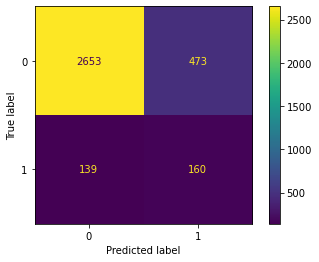

In [9]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)